In [1]:
import matplotlib.pyplot as plt

In [2]:
from learning_in_games import *
import numpy as np

In [6]:
N_AGENTS = 100
N_STATES = 1
N_ACTIONS = 3
N_ITER = 10000

gameConfig = RouteConfig(N_AGENTS, N_ACTIONS, N_STATES, N_ITER, cost=0)
gameConfig.n_iter = N_ITER

EPSILON = "DECAYED"
mask = np.zeros(N_AGENTS)
mask[:] = 1
GAMMA = 0
ALPHA = 0.01

QINIT = "UNIFORM"  #np.array([-1, -1, -2])

Q = initialize_q_table(QINIT, gameConfig)

agentConfig = EpsilonGreedyConfig(ALPHA, GAMMA, QINIT, EPSILON)

if ALPHA == "UNIFORM":
    ALPHA = np.random.random_sample(size=N_AGENTS)

exp_start, exp_end, exp_decay = initialize_exploration_rates(gameConfig, agentConfig)

M = {}
ind = np.arange(N_AGENTS)
S = np.random.randint(N_STATES, size=N_AGENTS)
R = np.ones(N_AGENTS) * -2
A = np.random.randint(N_ACTIONS, size=N_AGENTS)

vectors = []

for t in range(N_ITER):

    agentConfig.epsilon = update_exploration_rates(t, N_ITER, exp_start=exp_start, exp_end=exp_end)
    
    A = e_greedy_select_action(Q, S, agentConfig)

    R, travel_time_per_route = braess_augmented_network(A, gameConfig)

    Q, sum_of_belief_updates = bellman_update_q_table(Q, S, A, R, S, agentConfig=agentConfig)
    
    ## SAVE PROGRESS DATA
    M[t] = {"nA": np.bincount(A, minlength=3),
            "R": R,
           }

NAME = f"run_vector_field"

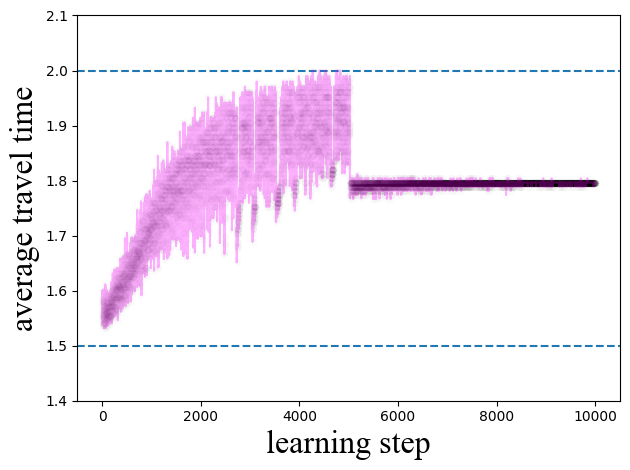

In [8]:
x_vals = np.arange(0, N_ITER, 1)
fig, ax = plt.subplots()
ax.axhline(y=2.0, ls="--")
ax.axhline(y=1.5, ls="--")
plt.plot(x_vals, [-M[t]["R"].mean() for t in x_vals], alpha=0.3, color="magenta")
plt.scatter(x_vals, [-M[t]["R"].mean() for t in x_vals], alpha=0.01, s=20, c="black")
plt.ylim(1.4, 2.1)
plt.xlabel("learning step", fontdict={"font": "Times New Roman", "fontsize": 23})
plt.ylabel("average travel time", fontdict={"font": "Times New Roman", "fontsize": 23})
plt.tight_layout()

In [586]:
x_0 = np.array([M[t]["nA"][0] for t in x_vals[:-1]])
y_0 = np.array([M[t]["nA"][1] for t in x_vals[:-1]])
z_0 = np.array([M[t]["nA"][2] for t in x_vals[:-1]])

vectors = [(M[i]["nA"] - M[i-1]["nA"]) for i in x_vals[1:]]

u = np.array([v[0] for v in vectors])
v = np.array([v[1] for v in vectors])
w = np.array([v[2] for v in vectors])

In [587]:
normal = np.ones(shape=(1,3)) #3d normal vector
normal = normal/np.sqrt((normal**2).sum())

In [588]:
y = np.array([0,0,1])  
y = y - np.dot(y, normal.T) * normal
y /= np.sqrt((y**2).sum())
y

array([[-0.40824829, -0.40824829,  0.81649658]])

In [589]:
x = np.cross(normal, y)

In [590]:
def project2d(A, x, y):
    return np.dot(A, x.T), np.dot(A, y.T)

In [591]:
points = np.vstack([x_0,y_0,z_0]).T

In [592]:
diffs = np.vstack([u,v,w]).T

In [593]:
bins = np.linspace(0,100,16)
pp, dd = average_and_bin(points, diffs, bins)

In [594]:
df_points = pd.DataFrame(points, columns=coords)
df_arrows = pd.DataFrame(diffs, columns=arrows)
pp = df_points.values
dd = df_arrows.values

In [595]:
x_c = (0, 0, 100)
x_u = (100, 0, 0)
x_d = (0, 100, 0)

In [596]:
points_x, points_y = project2d(pp, x, y)
diffs_x, diffs_y = project2d(dd, x, y)

In [597]:
colors = np.arange(len(points_x))/len(points_x)

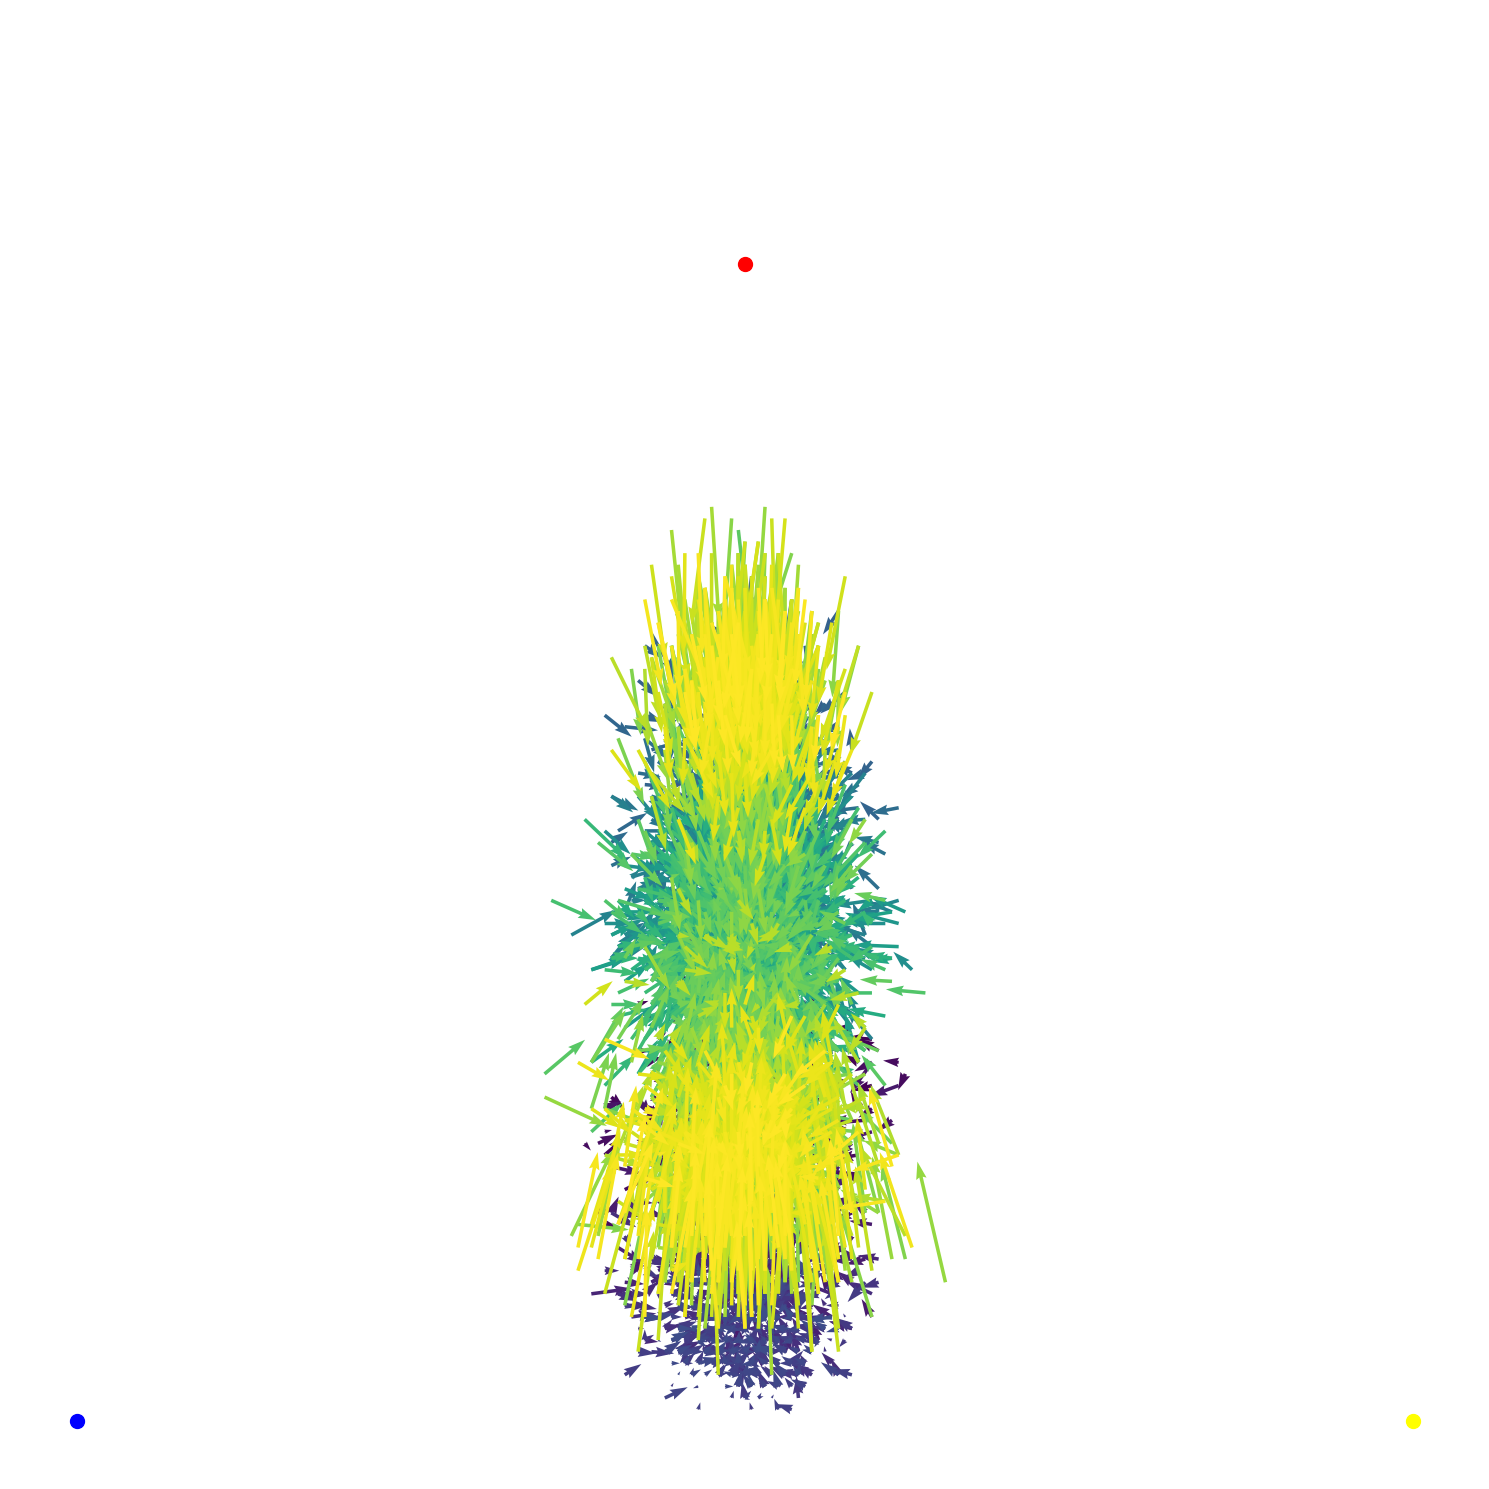

In [600]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.quiver(points_x, points_y, diffs_x, diffs_y, colors, angles="xy", scale=1000, alpha=1)
plt.scatter(*project2d(np.array(x_c), x, y), color="red", s=100)
plt.scatter(*project2d(np.array(x_u), x, y), color="yellow", s=100)
plt.scatter(*project2d(np.array(x_d), x, y), color="blue", s=100)
# plt.ylim(0, )
# plt.xlim(0, 100)
plt.axis("off")
plt.axis("square")
plt.tight_layout()
plt.savefig("braess_vector_field_epsilonDECAYED_uniformQ_alpha01_recommendations100.pdf")

# Paper figures

In [66]:
import seaborn as sns
sns.set_context("paper")

plt.style.use('paper.mplstyle')

# colors = sns.color_palette(palette='pastel', n_colors=3)
colors = sns.color_palette(palette='Set2', n_colors=3)
# M_data = [M, M2, M3]
labels = ['half-half', 'misaligned', 'aligned']
ls = ['-', '-.']

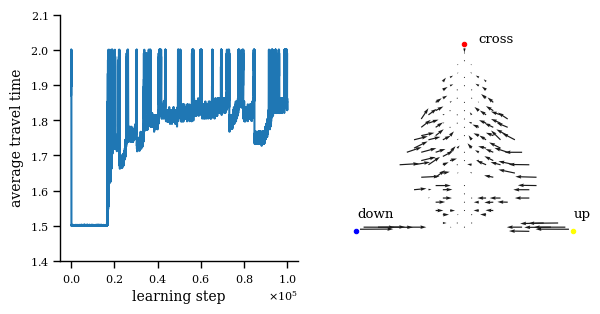

In [82]:
fig, [ax, ax2] = plt.subplots(ncols=2, figsize=(6.75, 3.2))

ax.plot([-M[t]["R"].mean() for t in range(N_ITER)], label="half-half")
ax.set_ylim((1.4, 2.1))
ax.set_xlabel('learning step')
ax.set_ylabel('average travel time')
ax.ticklabel_format(axis='both', style='sci', scilimits=(0,2), useMathText=True)


ax2.quiver(points_x, points_y, diffs_x, diffs_y, angles="xy", scale=1000,
           width=5e-3, headwidth=3, headlength=5,
           color='0.1')
ax2.scatter(*project2d(np.array(x_c), x, y), color='red', s=10)
ax2.annotate(text='cross', xy=project2d(np.array(x_c), x, y), xytext=(10,1), textcoords='offset points')
ax2.scatter(*project2d(np.array(x_u), x, y), color="yellow", s=10)
ax2.annotate(text='up', xy=project2d(np.array(x_u), x, y), xytext=(1,10), textcoords='offset points')

ax2.scatter(*project2d(np.array(x_d), x, y), color="blue", s=10)
ax2.annotate(text='down', xy=project2d(np.array(x_d), x, y), xytext=(1,10), textcoords='offset points')

# ax2.set_xlabel('vector field', **{"fontname": "Times New Roman", "fontsize": "31"})

ax2.axis("off")
ax2.set_aspect("equal")
sns.despine()

fig.savefig("braess_example_with_vectorfield.pdf", bbox_inches='tight')

widthfloat, optional
Shaft width in arrow units. All head parameters are relative to width.

The default depends on choice of units above, and number of vectors; a typical starting value is about 0.005 times the width of the plot.

headwidthfloat, default: 3
Head width as multiple of shaft width. See the notes below.

headlengthfloat, default: 5
Head length as multiple of shaft width. See the notes below.

headaxislengthfloat, default: 4.5
Head length at shaft intersection as multiple of shaft width. See the notes below.

minshaftfloat, default: 1
Length below which arrow scales, in units of head length. Do not set this to less than 1, or small arrows will look terrible!

minlengthfloat, default: 1
Minimum length as a multiple of shaft width; if an arrow length is less than this, plot a dot (hexagon) of this diameter instead.

colorcolor or color sequence, optional